In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy.io
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive
from pathlib import Path
!pip install torch numpy scipy matplotlib
import matplotlib.animation as animation
from scipy.io import loadmat

In [9]:

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/NS2D_InitialData.mat'

# Load the .mat file
data = loadmat(file_path)

# See all variable names inside the file
print(data.keys())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dict_keys(['__header__', '__version__', '__globals__', 'X_star', 't', 'U_star', 'p_star'])


In [14]:
data = scipy.io.loadmat(file_path)

N_train =5000

U_star = data['U_star']  # N x 2 x T
P_star = data['p_star']  # N x T
t_star = data['t']  # T x 1
X_star = data['X_star']  # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
p_test = P_star[:, 0:1]
u_test = U_star[:, 0:1, 0]
t_test = 10*np.ones((x_test.shape[0], x_test.shape[1]))

# Rearrange Data
XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star  # N x T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

# Training Data
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

In [15]:
"""
# Quiver Plot of Fluid Velocity
# This visualization displays how fluid motion evolves over time by plotting velocity vectors (u, v) at each grid point.
# The resulting animation is exported as a GIF for understanding fluid's behavior
"""

# Grid size
nx, ny = 100, 50

# Create meshgrid
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

# Unique sorted time steps
time_steps = np.unique(t[:, 0])

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
q = ax.quiver(X, Y, np.zeros_like(X), np.zeros_like(Y), scale=15)

# Function to update the animation for each time step
def update(frame):
    ax.clear()
    t_val = time_steps[frame]
    t_idx = np.where(np.isclose(t[:, 0], t_val))[0]

    u_frame = u[t_idx].reshape(ny, nx)
    v_frame = v[t_idx].reshape(ny, nx)

    ax.quiver(X, Y, u_frame, v_frame, scale=20, color='black')
    ax.set_title(f"Velocity Field at t = {t_val:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    return []

ani = animation.FuncAnimation(fig, update, frames=len(time_steps), interval=200)

# Saving The gif in google colab
ani.save("/content/drive/My Drive/velocity_quiver_animation.gif", writer="pillow", fps=5)

plt.close()


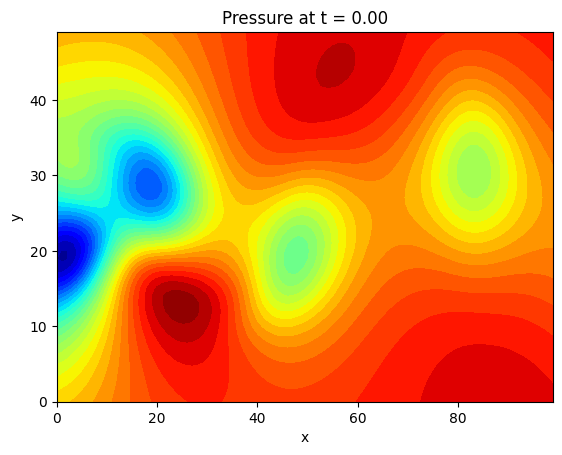

In [16]:
"""
# Heatmap of Pressure Over Time
# Chart creates a 2-dimensional pressure map with dimensions 100 (x-axis) × 50 (y-axis) = 5000 spatial points
# The output is saved as a GIF showing how pressure changes across the domain over time
"""
nx, ny = 100, 50

time_steps = np.unique(t)

fig, ax = plt.subplots()

# Function to update the animation for each time step
def update(frame):
    ax.clear()
    t_val = time_steps[frame]
    t_idx = np.where(np.isclose(t[:, 0], t_val))[0]
    p_frame = p[t_idx].reshape(ny, nx)
    ax.contourf(p_frame, levels=30, cmap='jet')
    ax.set_title(f"Pressure at t = {t_val:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    return []

# Saving The gif in google colab
ani = animation.FuncAnimation(fig, update, frames=len(time_steps), interval=200)

ani.save("/content/drive/My Drive/pressure_evolution.gif", writer="pillow", fps=5)
plt.close()